# Automatic Care Symbol Detection (YOLO)

#### *Run the cell below to make sure all dependencies are installed.*

In [ ]:
# make sure all dependencies are installed
!pip install ultralytics Pillow matplotlib ipython

In [18]:
from ultralytics import YOLO
from PIL import ImageFont, ImageDraw, Image
import matplotlib.font_manager as fm
from IPython.display import display

In [19]:
# load model
model = YOLO("./model.pt")

#### *Enter your image file's path in the cell below. You also have 4 sample images in the folder that you can test out.*

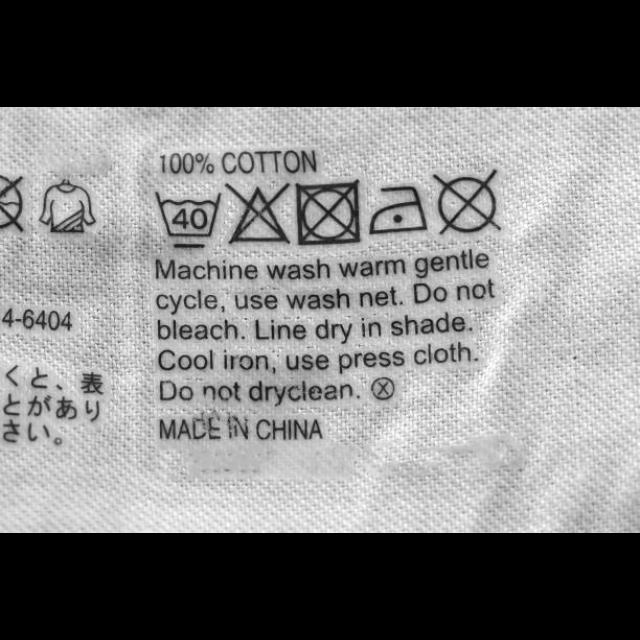

In [56]:
image_path = "./sample_image.jpg" # enter image path here 
image = Image.open(image_path)
display(image)

In [57]:
# predict boxes and confidence scores
results = model(image_path)


image 1/1 /Users/athul/Library/Mobile Documents/com~apple~CloudDocs/Courses/CSE 6367 Computer Vision/Project/Github/Final Product/sample_image.jpg: 640x640 1 40C, 1 DN_bleach, 2 DN_dry_cleans, 1 DN_tumble_dry, 1 iron_low, 1 iron_medium, 258.7ms
Speed: 1.9ms preprocess, 258.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


In [58]:
# function to draw bounding boxes
def draw_YOLO_boxes(image_pil, results, labels, confidence_threshold=0.75):
    image_pil = image_pil.convert("RGBA")
    W, H = image_pil.size
    scale = min(W, H) / 640.0

    # scaling factors
    box_thickness = max(2, int(4 * scale))
    font_base_size = max(10, int(15 * scale))
    legend_font_size = max(14, int(18 * scale))

    # Load fonts
    font_path = fm.findfont("DejaVu Sans")
    font_legend = ImageFont.truetype(font_path, legend_font_size)

    # Extract predictions
    boxes = [box.xyxy[0].cpu().numpy() for box in results[0].boxes]
    scores = [box.conf[0].item() for box in results[0].boxes]
    class_ids = [int(box.cls[0].item()) for box in results[0].boxes]

    overlay_boxes = Image.new("RGBA", image_pil.size, (0, 0, 0, 0))
    draw_boxes = ImageDraw.Draw(overlay_boxes)

    overlay_labels = Image.new("RGBA", image_pil.size, (0, 0, 0, 0))
    draw_labels = ImageDraw.Draw(overlay_labels)

    BOX_COLOR = (255, 0, 0, 255)
    TEXT_COLOR = (255, 255, 255, 255)

    detected_classes = set()

    # draw boxes
    for box, cls_id, score in zip(boxes, class_ids, scores):
        if score < confidence_threshold:
            continue
        x1, y1, x2, y2 = map(int, box)
        draw_boxes.rectangle([x1, y1, x2, y2], outline=BOX_COLOR, width=box_thickness)
        detected_classes.add(cls_id)

    image_pil = Image.alpha_composite(image_pil, overlay_boxes)

    # draw labels
    for box, cls_id, score in zip(boxes, class_ids, scores):
        if score < confidence_threshold:
            continue

        x1, y1, x2, y2 = map(int, box)
        cls_int = int(cls_id)
        label_text = f"{cls_int}"

        box_h = max(1, y2 - y1)
        dyn_font_size = max(font_base_size, int(box_h * 0.35))
        font_dynamic = ImageFont.truetype(font_path, dyn_font_size)

        tbox = draw_labels.textbbox((0, 0), label_text, font=font_dynamic)
        text_w, text_h = tbox[2] - tbox[0], tbox[3] - tbox[1]

        pad_x = int(dyn_font_size * 0.4)
        pad_y = int(dyn_font_size * 0.25)
        label_w = text_w + 2 * pad_x
        label_h = text_h + 2 * pad_y

        label_x = x1
        label_y = y1 - label_h - 1
        if label_y < 0:
            label_y = y1 + 1

        if label_x + label_w > W:
            label_x = W - label_w - 1

        draw_labels.rectangle(
            [label_x, label_y, label_x + label_w, label_y + label_h],
            fill=BOX_COLOR
        )

        text_x = label_x + pad_x
        text_y = label_y + pad_y - int(0.3 * pad_y)
        draw_labels.text((text_x, text_y), label_text, font=font_dynamic, fill=TEXT_COLOR)

    # Legend
    if detected_classes:
        sorted_classes = sorted(detected_classes)
        legend_lines = [f"{i}: {labels[i]}" for i in sorted_classes]

        pad = int(8 * scale)
        line_h = font_legend.getbbox("Ay")[3] + int(6 * scale)
        tmp_draw = ImageDraw.Draw(Image.new("RGB", (1, 1)))
        max_w = max(tmp_draw.textlength(s, font=font_legend) for s in legend_lines)
        legend_w = int(max_w + 2 * pad)
        legend_h = int(len(legend_lines) * line_h + 2 * pad)

        start_x = int(10 * scale)
        start_y = H - legend_h - int(10 * scale)

        draw_labels.rectangle(
            [start_x, start_y, start_x + legend_w, start_y + legend_h],
            fill=(0, 0, 0, 160)
        )

        for i, line in enumerate(legend_lines):
            y = start_y + pad + i * line_h
            draw_labels.text((start_x + pad, y), line, font=font_legend, fill=(255, 255, 0, 255))

    image_pil = Image.alpha_composite(image_pil, overlay_labels)

    return image_pil


# call function
annotated_image = draw_YOLO_boxes(image, results, model.names)

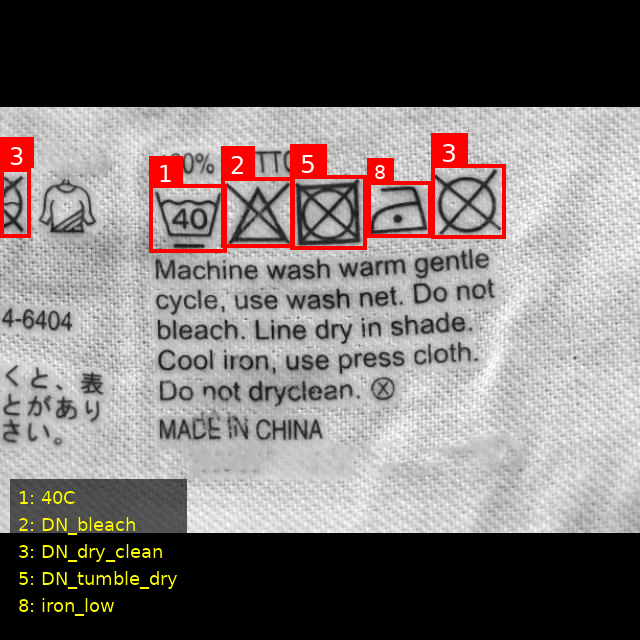

In [59]:
# display annotated image
display(annotated_image)